# Evaluation of the Models Using Real Pictures of Dogs in my Neighbourhood

### Load Each of the Models (VGG-16, Inception v3, Mobilenet v2)

These weights can be found on GitHub under "model_weights". They were trained using the file "CNN Training" which is in the same directory as this one. 

In [1]:
import os

data_dir = '../input/stanford-dogs-dataset/images/Images'
class_names = sorted([folder for folder in os.listdir(data_dir)])

import numpy as np
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array

num_classes = len(class_names)
img_width, img_height = 160, 160

# Load the VGG16 model without weights and the top layers
base_model = VGG16(weights=None, include_top=False, input_shape=(img_width, img_height, 3))

# Add the custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions_vgg = Dense(num_classes, activation='softmax')(x)

# Create the new model
vgg_model = Model(inputs=base_model.input, outputs=predictions_vgg)

# Load the weights
vgg_model.load_weights('/kaggle/input/models/dog_breed_classifier_vgg.h5')

In [2]:
from tensorflow.keras.applications import InceptionV3

img_width, img_height = 160, 160

base_model = InceptionV3(weights=None, include_top=False, input_shape=(img_width, img_height, 3))

# Add the custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions_inc = Dense(num_classes, activation='softmax')(x)

# Create the new model
inc_model = Model(inputs=base_model.input, outputs=predictions_inc)

# Load the weights
inc_model.load_weights('/kaggle/input/models/dog_breed_classifier_inc.h5')

In [3]:
from tensorflow.keras.applications import MobileNetV2

img_width, img_height = 160, 160

base_model = MobileNetV2(weights=None, include_top=False, input_shape=(img_width, img_height, 3))

# Add the custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions_mn = Dense(num_classes, activation='softmax')(x)

# Create the new model
mn_model = Model(inputs=base_model.input, outputs=predictions_mn)

# Load the weights
mn_model.load_weights('/kaggle/input/models/dog_breed_classifier_mn.h5')

### A *bunch* of Helper Functions Until the Next Markdown Cell

See what they each do if you wish in the function signatures.

In [4]:
import tensorflow as tf
import numpy as np

models = [vgg_model, inc_model, mn_model]

# Helper function. Takes in label from dataset and cleans it up for printing.
def extract_breed_name(label):
    return label.split('-', 1)[-1]

# Returns the predictions from each of the CNNs for the image give. num_prob 
# states the number of the top breeds probabilities you would like to be returned. 
def predict_breeds(models, image_path, num_prob=5):
    img_width, img_height = 160, 160
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    class_names = sorted([folder for folder in os.listdir(data_dir)])
    results = {}

    for i,model in enumerate(models):
        predictions = model.predict(img_array)[0]
        top_indices = predictions.argsort()[-num_prob:][::-1]
        top_breeds = [class_names[i] for i in top_indices]
        top_probs = predictions[top_indices]
        top_dict = dict(zip(top_breeds, top_probs))
        if i==0:
            model_name = "vgg16"
        elif i==1:
            model_name = "inceptionv3"
        elif i==2: 
            model_name = "mobilenetv2"
        results[model_name] = top_dict

    return results

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adjust probabilities using their breed-wise accuracy. This way, models less accuracate
# for the breeds they ouputted will be weighed less.
def adjust_probabilities(results, breed_test_accuracy):
    adjusted_results = {}
    
    for model_name, top_probs_dict in results.items():
        adjusted_probs_dict = {}
        for breed, prob in top_probs_dict.items():
            breed_name = breed
            if breed_name in breed_test_accuracy:
                adjusted_prob = prob * breed_test_accuracy[breed_name]
            else:
                adjusted_prob = prob
            adjusted_probs_dict[breed_name] = adjusted_prob
        adjusted_results[model_name] = adjusted_probs_dict

    return adjusted_results

# Generate the accuracies for each breed for a certain model. Used in the function above
def breed_accuracies(model, generator):
    # Predict on the validation data
    y_pred_probs = model.predict(generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # True labels
    y_true = generator.classes

    # Breed-wise accuracies
    accuracies = {}
    for breed_idx, breed_name in enumerate(generator.class_indices):
        correct_preds = np.sum((y_true == breed_idx) & (y_pred == breed_idx))
        total_preds = np.sum(y_true == breed_idx)
        accuracies[breed_name] = correct_preds / total_preds

    return accuracies

# Combine the breed wise accuracies for a list of all breed-wise accuracies for
# the neural networks. 
def combine_accuracies(accuracies_list):
    combined_accuracies = {}
    for breed_accuracies in accuracies_list:
        for breed, accuracy in breed_accuracies.items():
            breed_name = breed
            if breed_name in combined_accuracies:
                combined_accuracies[breed_name].append(accuracy)
            else:
                combined_accuracies[breed_name] = [accuracy]
    
    # Calculate the average accuracy for each breed
    for breed, accuracies in combined_accuracies.items():
        combined_accuracies[breed] = np.mean(accuracies)
    
    return combined_accuracies

# Compile the models
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

inc_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mn_model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Reconstruct the val_datagen
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_generator = val_datagen.flow_from_directory(data_dir,
                                                target_size=(160, 160),
                                                batch_size=16,
                                                class_mode='categorical',
                                                subset='validation',
                                                shuffle=False)

# Combine the three model accuracies into one dict of the conglomerated weights for
# each breed
def combine_models_predictions(adjusted_results):
    combined_predictions = {}

    for model_name, top_probs_dict in adjusted_results.items():
        for breed, prob in top_probs_dict.items():
            if breed in combined_predictions:
                combined_predictions[breed] += prob
            else:
                combined_predictions[breed] = prob

    return combined_predictions

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Make the final prediction. This will take the top weights, and if x of the top weights 
# constitute over 75% of the total weights, then...
# If x = 1, it will return the one breed.
# If x = 2, a linear regression model will be trained to assist in the ensemble
# If x >= 3, a KNN model will be trained to assist in the ensemble
def final_prediction(image_path, combined_predictions, train_generator, val_generator, threshold=0.75, res_num=1):
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = img_array.reshape(1, -1)

    # Sort the combined predictions
    sorted_predictions = sorted(combined_predictions.items(), key=lambda x: x[1], reverse=True)

    # Calculate the total weight
    total_weight = sum([prob for breed, prob in sorted_predictions])

    # Initialize accumulative weight and the list of top breeds
    accumulative_weight = 0
    top_breeds = []

    # Find the top breeds that constitute over threshold% of the total weight
    for breed, prob in sorted_predictions:
        top_breeds.append(breed)
        accumulative_weight += prob
        if accumulative_weight / total_weight >= threshold:
            break
    
    if len(top_breeds) == 1:
        return {top_breeds[0]: combined_predictions[top_breeds[0]]}
    elif len(top_breeds) == 2:
        model = LogisticRegression()
    else:
        model = KNeighborsClassifier(n_neighbors=len(top_breeds))

    # Get the indices of the top breeds
    top_breed_indices = [train_generator.class_indices[breed] for breed in top_breeds]

    # Filter the train and validation data for the top breeds
    X_train, y_train = [], []
    X_val, y_val = [], []

    for idx, (data, label) in enumerate(train_generator):
        mask = np.isin(label.argmax(axis=1), top_breed_indices)
        filtered_data = data[mask]
        filtered_labels = label[mask].argmax(axis=1)
        X_train.extend(filtered_data)
        y_train.extend(filtered_labels)
        if idx == len(train_generator) - 1:
            break

    for idx, (data, label) in enumerate(val_generator):
        mask = np.isin(label.argmax(axis=1), top_breed_indices)
        filtered_data = data[mask]
        filtered_labels = label[mask].argmax(axis=1)
        X_val.extend(filtered_data)
        y_val.extend(filtered_labels)
        if idx == len(val_generator) - 1:
            break

    X_train = np.array(X_train).reshape(-1, 160 * 160 * 3)
    y_train = np.array(y_train)
    X_val = np.array(X_val).reshape(-1, 160 * 160 * 3)
    y_val = np.array(y_val)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions and calculate accuracies
    y_val_pred = model.predict(X_val)
    accuracy = np.sum(y_val_pred == y_val) / len(y_val)

    # Update combined predictions with the model's predictions and accuracies
    model_probs = model.predict_proba(img_array)[0]
    for idx, breed in enumerate(top_breeds):
        prob = model_probs[idx] * accuracy
        combined_predictions[breed] += prob
    
    # Sort the combined predictions by weight
    sorted_combined_predictions = sorted(combined_predictions.items(), key=lambda x: x[1], reverse=True)

    # Return the dictionary containing the top res_num breeds and their weights
    return dict(sorted_combined_predictions[:res_num])


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=(160, 160),
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    subset='training')

import matplotlib.pyplot as plt

# Takes in predictions and plots them
def plot_breed_distribution(predictions, title):
    breeds = [extract_breed_name(breed) for breed in predictions.keys()]
    probabilities = list(predictions.values())

    plt.figure(figsize=(10, 5))
    plt.bar(breeds, probabilities)
    plt.xticks(rotation=90)
    plt.xlabel('Breed')
    plt.ylabel('Weight (acc * prob)')
    plt.title(title)
    plt.show()

# This averages the predictions across a list of them all coming from different images.
def average_predictions(predictions_list):
    breed_sums = {}
    breed_counts = {}

    for predictions in predictions_list:
        for model, breeds in predictions.items():
            for breed, prob in breeds.items():
                if breed in breed_sums:
                    breed_sums[breed] += prob
                    breed_counts[breed] += 1
                else:
                    breed_sums[breed] = prob
                    breed_counts[breed] = 1

    breed_avgs = {breed: breed_sums[breed]/breed_counts[breed] for breed in breed_sums.keys()}

    return breed_avgs

# This averages the predictions across a list of them. All coming from different images of the same dog/breed.
def average_dicts(dict_list):
    avg_dict = {}
    n = len(dict_list)
    for d in dict_list:
        for key, value in d.items():
            if key not in avg_dict:
                avg_dict[key] = 0
            avg_dict[key] += value/n
    return avg_dict

# Get breed-wise accuracies
breed_accuracies_list = [breed_accuracies(model, val_generator) for model in models]

# Takes in an image directory of one type of dog and ouputs the conglomerated results.
def plot_all_graphs(directory_path, models, train_generator, val_generator):

    # Combine breed-wise accuracies
    combined_breed_accuracies = combine_accuracies(breed_accuracies_list)

    # Create a list to store all results
    all_results = []
    all_adjusted_results = []
    all_combined_predictions = []
    all_top_breeds = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory_path, filename)

            # Get individual model's top breed predictions
            results = predict_breeds(models, image_path, num_prob=5)

            # Adjust probabilities based on breed test accuracy
            adjusted_results = adjust_probabilities(results, combined_breed_accuracies)

            # Combine model predictions
            combined_predictions = combine_models_predictions(adjusted_results)

            # Get the final top breed(s) prediction
            top_breeds = final_prediction(image_path, combined_predictions, train_generator, val_generator, res_num=5)

            all_results.append(results)
            all_adjusted_results.append(adjusted_results)
            all_combined_predictions.append(combined_predictions)
            all_top_breeds.append(top_breeds)

    avg_combined_predictions = average_dicts(all_combined_predictions)
    avg_top_breeds = average_dicts(all_top_breeds)

    plot_breed_distribution(avg_combined_predictions, 'Combined Models Predictions')
    plot_breed_distribution(avg_top_breeds, 'Final Prediction')
    
import matplotlib.image as mpimg

# Function just for visualizing the dogs I am testing
def display_images_in_dir(directory_path):
    # Get all file names in the directory
    file_names = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Determine number of image files
    num_images = sum([1 for file_name in file_names if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))])

    # Set up the figure and the array of subplots
    fig, axs = plt.subplots(1, num_images)

    i = 0  # Index to track current subplot

    for file_name in file_names:
        # Only display image files
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory_path, file_name)
            img = mpimg.imread(img_path)

            # Display the image on the appropriate subplot
            axs[i].imshow(img)
            axs[i].axis('off')
            i += 1

    plt.show()
    
from PIL import Image

def display_image_in_dir(directory_path):
    image_files = os.listdir(directory_path)
    num_images = len(image_files)

    for i in range(num_images):
        image_path = os.path.join(directory_path, image_files[i])
        img = Image.open(image_path)
        
        plt.figure()
        plt.imshow(img)
        plt.title(image_files[i])
        plt.show()


Found 4072 images belonging to 120 classes.
Found 16508 images belonging to 120 classes.
255/255 [==============================] - 18s 68ms/step


# Evaluation Section

### Kyle (West Highland Terrier)

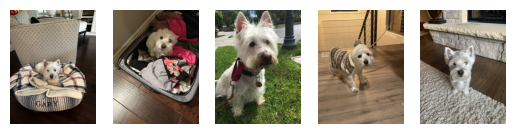

In [5]:
display_images_in_dir("/kaggle/input/kyle-wht")

1/1 [==============================] - 0s 24ms/step


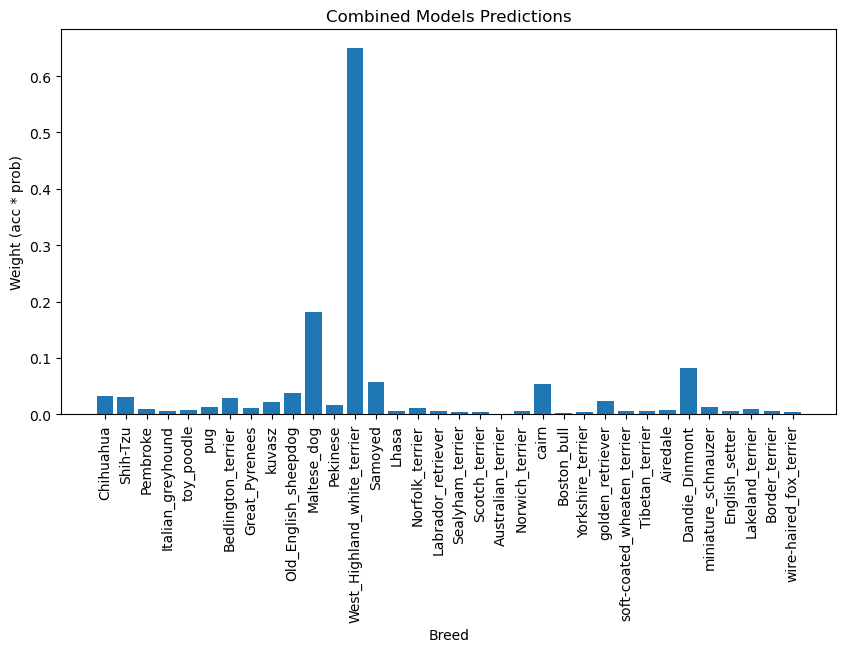

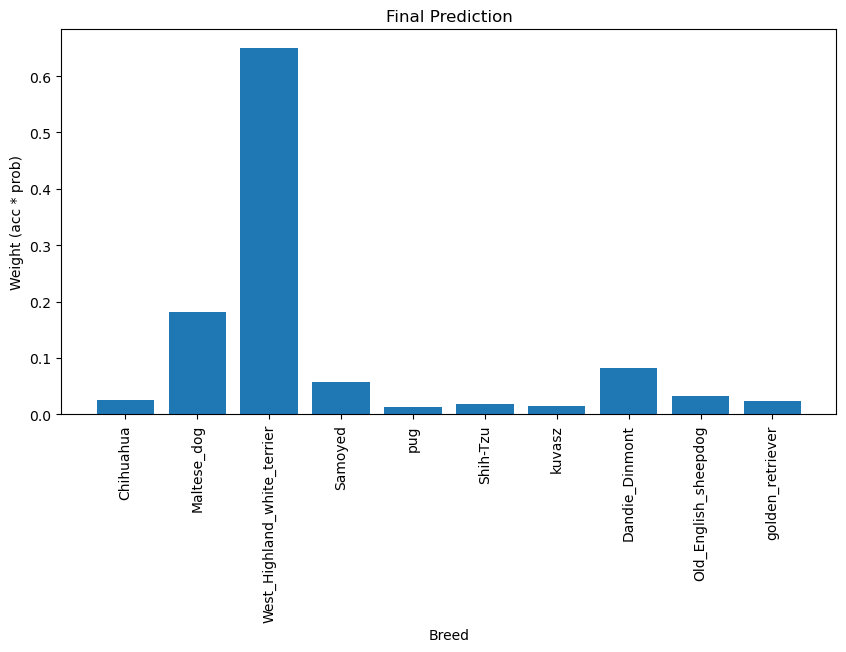

In [6]:
plot_all_graphs("/kaggle/input/kyle-wht", models, train_generator, val_generator)

## Bailey (Saint Bernard)

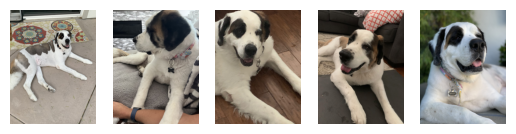

In [7]:
display_images_in_dir("/kaggle/input/bailey")

1/1 [==============================] - 0s 30ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


1/1 [==============================] - 0s 25ms/step


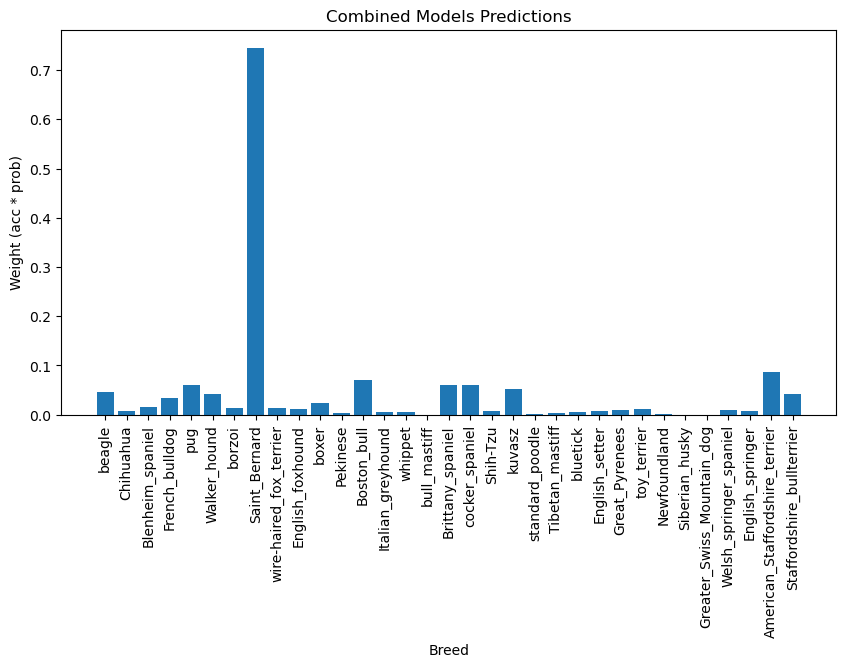

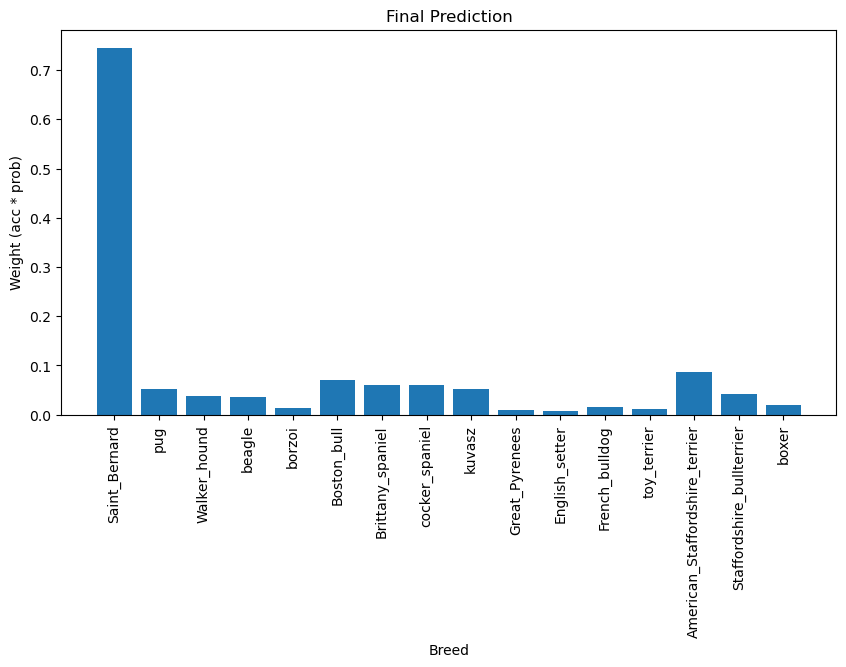

In [8]:
plot_all_graphs("/kaggle/input/bailey", models, train_generator, val_generator)

## Maddie (50% German Shepherd, 12.5% Siberian Husky, 12.5% Doberman, 12.5% Rottweiler, 12.5% other)

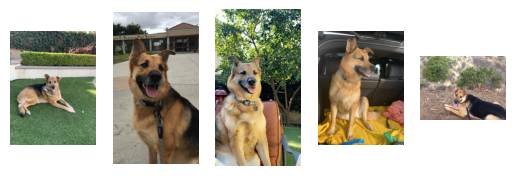

In [9]:
display_images_in_dir("/kaggle/input/maddie")

1/1 [==============================] - 0s 24ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


1/1 [==============================] - 0s 22ms/step


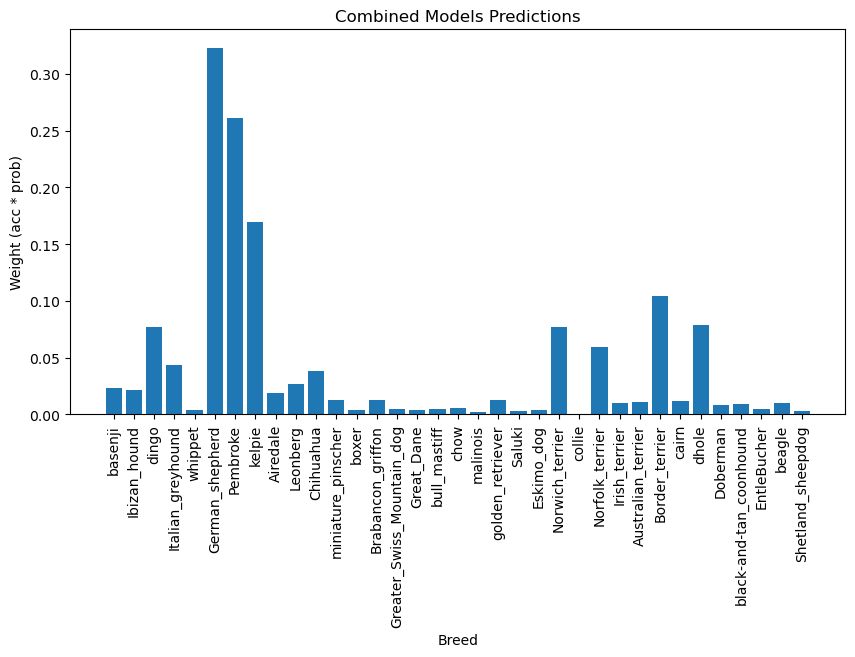

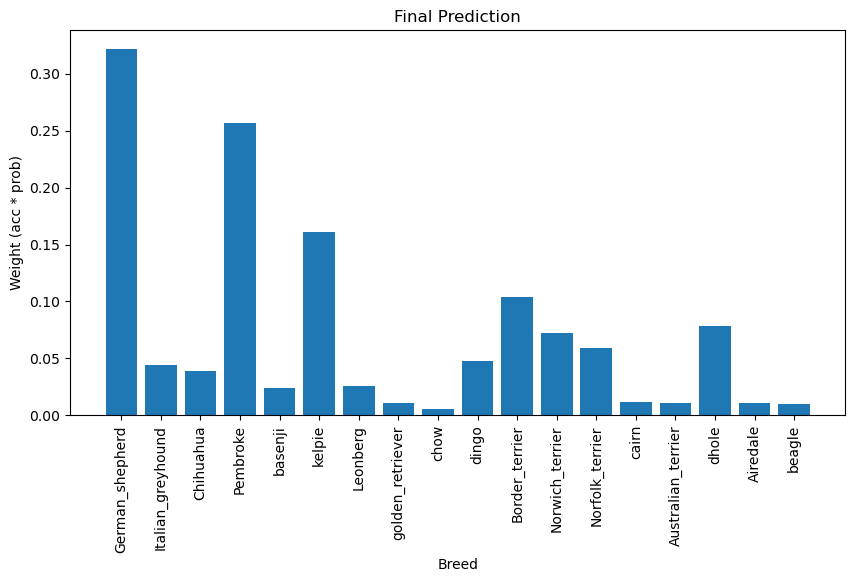

In [10]:
plot_all_graphs("/kaggle/input/maddie", models, train_generator, val_generator)

## Millie (Red Heeler, meaning 50% Dingo, 50% Australian Cattle Dog)

This is the last evaluation as it is arguable the hardest for the model to predict. More details below. 

Kelpie can also be accepted for Millie. Kelpie's are also Australian Dogs that are around the same size as Heelers. Since Heelers are not part of the dataset, we will look for Kelpie/Dingo in the results. 

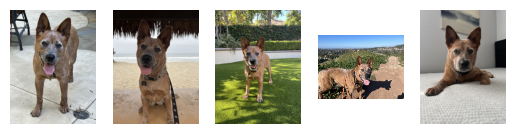

In [11]:
display_images_in_dir("/kaggle/input/millie")

1/1 [==============================] - 0s 22ms/step


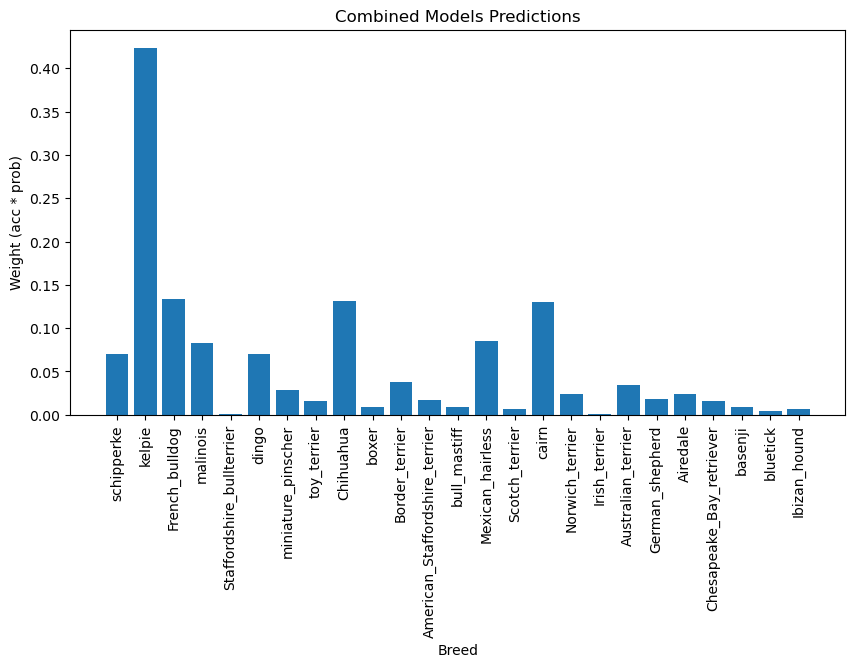

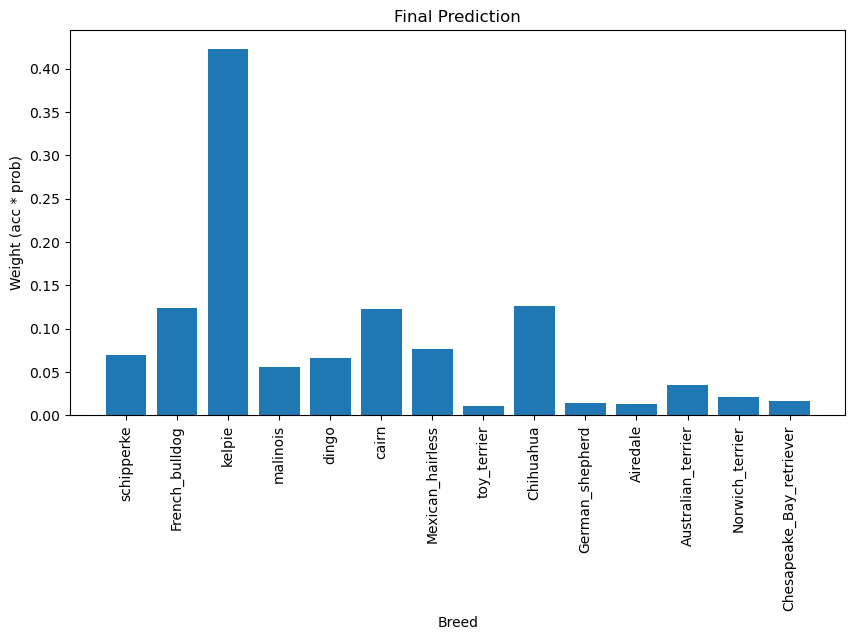

In [12]:
plot_all_graphs("/kaggle/input/millie", models, train_generator, val_generator)

## Northeastern Mascot: The Husky (50% Husky, 50% Spirit)

Let's see how the model interprets things that are not dogs, but resemble them. 

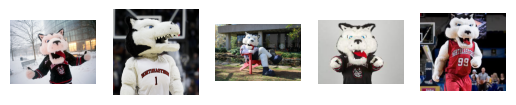

In [13]:
display_images_in_dir("/kaggle/input/neu-husky")

1/1 [==============================] - 0s 25ms/step


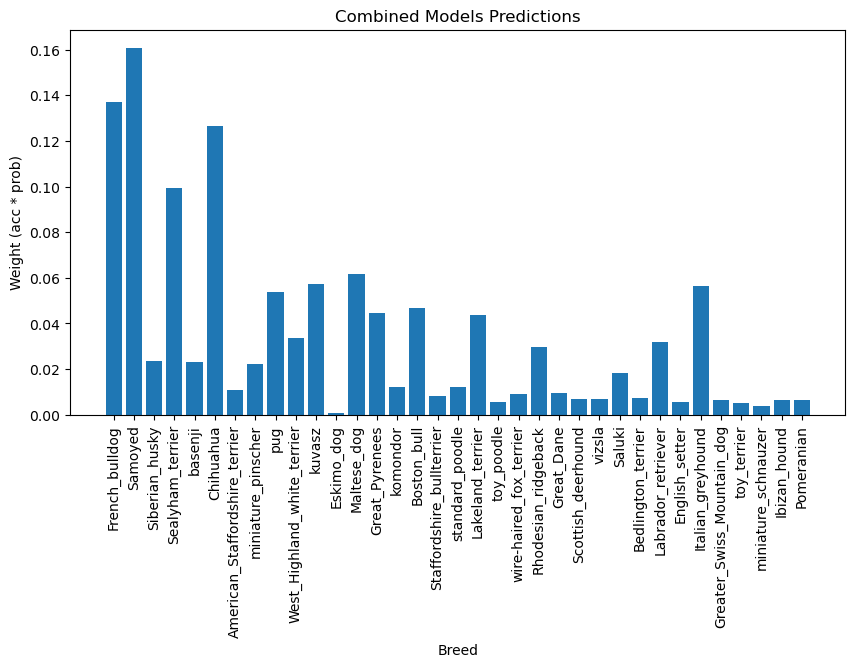

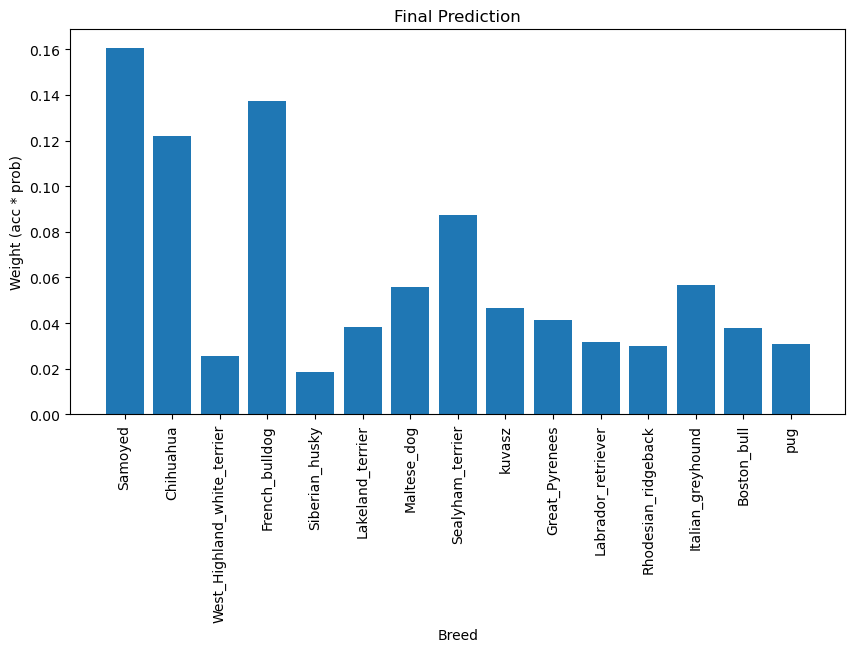

In [14]:
plot_all_graphs("/kaggle/input/neu-husky", models, train_generator, val_generator)

## Heashot of Myself

Let's see how the model does on a picture of a human (for fun).

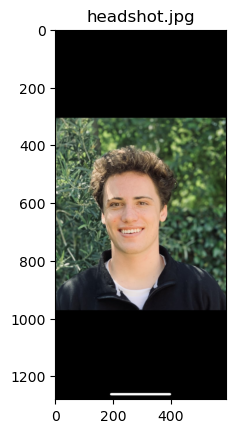

In [15]:
display_image_in_dir("/kaggle/input/myself")

1/1 [==============================] - 0s 43ms/step


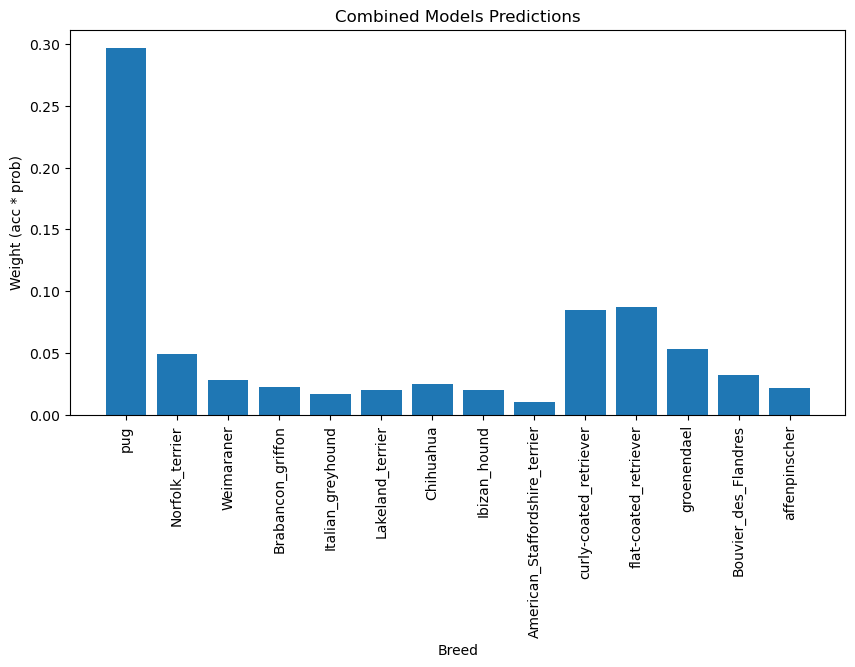

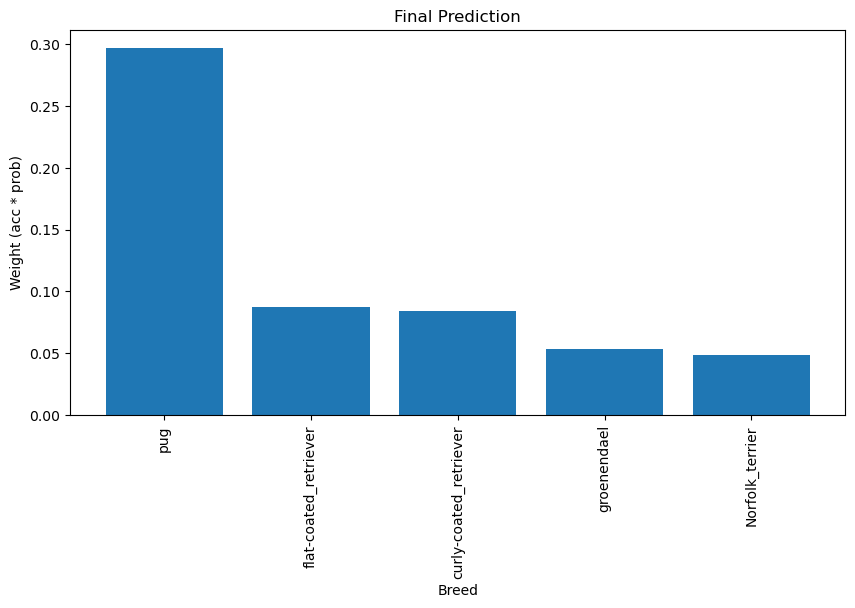

In [16]:
plot_all_graphs("/kaggle/input/myself", models, train_generator, val_generator)